In [1]:
import os
import glob
import datetime
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

pd.set_option('max_rows', 200)
pd.set_option('max_columns', 200)

perc = [0.01, 0.05, 0.1, 0.25, 0.5, 0.75, 0.9, 0.95, 0.99]

In [12]:
startDate = '20200819'
endDate = '20200819'

readPath = r'\\192.168.10.30\Kevin_zhenyu\orderLog\equityTradeLogs'
dataPathLs = np.array(glob.glob(os.path.join(readPath, 'speedCompare***.csv')))
dateLs = np.array([os.path.basename(i).split('_')[1].split('.')[0] for i in dataPathLs])
dataPathLs = dataPathLs[(dateLs >= startDate) & (dateLs <= endDate)]
rawOrderLog = []
for thisDate, thisPath in zip(dateLs, dataPathLs):
    data = pd.read_csv(thisPath)
    data = data.rename(columns={'mdClockAtArrival': 'caamd'})
    rawOrderLog += [data]
rawOrderLog = pd.concat(rawOrderLog, sort=False)

# rawOrderLog = pd.read_pickle(r'A:\temp\zs66 speed\speedCompare_zs62_20200813.pkl')
rawOrderLog = rawOrderLog.fillna(0)
for col in ['clockAtArrival', 'caamd', 'secid', 'updateType', 'vai', 'absFilledThisUpdate', 'orderDirection', 'absOrderSize',
            'absOrderSizeCumFilled', 'date', 'accCode', 'mse']:
    rawOrderLog[col] = rawOrderLog[col].astype('int64')   
rawOrderLog = rawOrderLog.sort_values(by=['date', 'secid', 'vai', 'accCode', 'clockAtArrival']).reset_index(drop=True)

rawOrderLog = rawOrderLog[rawOrderLog["secid"] >= 1000000]


targetStock = rawOrderLog['secid'].unique()
targetStock = np.array([int(str(i)[1:]) for i in targetStock])
targetStockSZ = sorted(targetStock[targetStock < 600000])
targetStockSH = sorted(targetStock[targetStock >= 600000])

rawOrderLog['clock'] = rawOrderLog['clockAtArrival'].apply(lambda x: datetime.datetime.fromtimestamp(x/1e6))
rawOrderLog['broker'] = rawOrderLog['accCode'] // 100
rawOrderLog["broker"] = np.where(rawOrderLog["accCode"].astype(str).apply(lambda x: len(x) == 6), rawOrderLog['accCode'] // 10000, rawOrderLog["broker"])
rawOrderLog['colo_broker'] = rawOrderLog['colo'].str[:2] + '_' + rawOrderLog['broker'].astype('str')
rawOrderLog['order'] = rawOrderLog.groupby(['date', 'accCode', 'secid', 'vai']).grouper.group_info[0]
rawOrderLog['group'] = rawOrderLog.groupby(['date', 'secid', 'vai']).grouper.group_info[0]
rawOrderLog['startClock'] = rawOrderLog.groupby(['order'])['clockAtArrival'].transform('first')
rawOrderLog['duration'] = rawOrderLog['clockAtArrival'] - rawOrderLog['startClock']
rawOrderLog['orderPrice'] = rawOrderLog['orderPrice'].apply(lambda x: round(x, 2))
rawOrderLog['tradePrice'] = rawOrderLog['tradePrice'].apply(lambda x: round(x, 2))
rawOrderLog['orderDirection1'] = np.where(rawOrderLog["orderDirection"] == -2, -1, np.where(
    rawOrderLog["orderDirection"] == 2, 1, rawOrderLog["orderDirection"]))
orderLog = rawOrderLog.copy()

### make sure updateType == 7 orders < 20 per account, < 100 in total
if orderLog[orderLog['updateType'] == 7].shape[0] != 0:
    assert(orderLog[orderLog['updateType'] == 7].groupby('accCode')['vai'].count().max() < 20)
    assert(orderLog[orderLog['updateType'] == 7].groupby('accCode')['vai'].count().sum() < 100)

### make sure no order has shares > 80w or notional > 800w
orderLog['orderNtl'] = orderLog['absOrderSize'] * orderLog['orderPrice']
# assert(orderLog[orderLog['absOrderSize'] > 800000].shape[0] == 0)
# assert(orderLog[orderLog['orderNtl'] > 8000000].shape[0] == 0)
if orderLog[orderLog['absOrderSize'] > 800000].shape[0] > 0:
    print('some order quantity are > 80w')
    display(orderLog[orderLog['absOrderSize'] > 800000][['date', 'accCode', 'secid', 'vai', 'absOrderSize', 'orderPrice',
                                                         'orderNtl', 'orderDirection', 'clock', 'order']])
            
if orderLog[orderLog['orderNtl'] > 8000000].shape[0] > 0:
    print('some order ntl are > 800w')
    display(orderLog[orderLog['orderNtl'] > 8000000][['date', 'accCode', 'secid', 'vai', 'absOrderSize', 'orderPrice',
                                                      'orderNtl', 'orderDirection', 'clock', 'order', "updateType", 
                                                      "tradePrice", "absOrderSizeCumFilled", "absFilledThisUpdate"]])

### make sure same direction in same colo_broker
orderLog['directNum'] = orderLog.groupby(['date', 'secid', 'vai'])['orderDirection1'].transform('nunique')
if len(orderLog[orderLog['directNum'] != 1]) > 0:
    print('opposite direction for same date, same secid, same vai')
    display(orderLog[orderLog['directNum'] != 1][['date', 'accCode', 'secid', 'vai', 'orderDirection']])
    orderLog = orderLog[orderLog['directNum'] == 1]

assert((orderLog.groupby(['date', 'secid', 'vai'])['orderDirection1'].nunique() == 1).all() == True)

## make sure each account, secid, vai only has one insertion
a = orderLog[orderLog['updateType'] == 0].groupby(['date', 'accCode', 'secid', 'vai', 'order'])['clockAtArrival'].count()
if len(a[a > 1]) > 0:
    print('more than one insertion at same time')
    a = a[a>1].reset_index()
    display(a)
    orderLog = orderLog[~(orderLog['order'].isin(a['order'].unique()))]

orderLog['isMsg'] = np.where(orderLog['updateType'] == 0, 
                             np.where(orderLog['mse'] == 100, 1, 0), np.nan)
orderLog['isMsg'] = orderLog.groupby(['order'])['isMsg'].ffill()

placeSZE = orderLog[(orderLog['secid'] >= 2000000) & (orderLog['updateType'] == 0)]
print('%.2f%% SZE orders triggered by msg data'%(placeSZE[placeSZE['isMsg'] == 1].shape[0]/placeSZE.shape[0]*100))

### make sure there is no unexpected updateType 
def getTuple(x):
    return tuple(i for i in x)

checkLog = orderLog[~((orderLog['updateType'] == 4) & (orderLog.groupby(['order'])['updateType'].shift(-1) == 4))]
checkLog = checkLog.groupby(['order'])['updateType'].apply(lambda x: getTuple(x)).reset_index()
checkLog['status'] = np.where(checkLog['updateType'].isin([(0, 2, 4), (0, 2, 2, 4), (0, 2, 2, 1, 4), (0, 2, 1, 4), (0, 2, 1, 2, 4), (0, 2, 4, 1, 4), (0, 4), (0, 4, 1, 4), (0, 2, 2, 4, 1, 4), (0, 4, 2, 4)]),0,
                     np.where(checkLog['updateType'].isin([(0, 2, 4, 1, 3), (0, 2, 4, 1, 4, 3), (0, 2, 1, 4, 3), (0, 4, 1, 3), (0, 2, 2, 4, 1, 4, 3), (0, 2, 2, 4, 1, 3), (0, 2, 2, 1, 4, 3), (0, 4, 2, 4, 1, 3), (0, 4, 2, 1, 3), (0, 2, 4, 2, 1, 3), (0, 4, 1, 4, 3), (0, 4, 2, 4, 1, 4, 3)]), 1,
                     np.where(checkLog['updateType'].isin([(0, 2, 1, 3), (0, 2, 2, 1, 3)]), 2,
                     np.where(checkLog['updateType'].isin([(0, 3)]), 3,
                     np.where(checkLog['updateType'].isin([(0,), (0, 2), (0, 2, 1), (0, 2, 2), (0, 2, 4, 1)]), 4, 5)))))
display(set(checkLog["updateType"].unique()) - set([(0, 2, 4), (0, 2, 2, 4), (0, 2, 2, 1, 4), (0, 2, 1, 4), (0, 2, 1, 2, 4),
                                                    (0, 2, 4, 1, 4), (0, 4), (0, 4, 1, 4), (0, 2, 2, 4, 1, 4), (0, 4, 2, 4), 
                                                    (0, 2, 4, 1, 3), (0, 2, 4, 1, 4, 3), (0, 2, 1, 4, 3), (0, 4, 1, 3),
                                                    (0, 2, 2, 4, 1, 4, 3), (0, 2, 2, 4, 1, 3), (0, 2, 2, 1, 4, 3),
                                                    (0, 4, 2, 4, 1, 3), (0, 4, 2, 1, 3), (0, 2, 1, 3), (0, 2, 2, 1, 3),
                                                    (0, 3), (0,), (0, 2), (0, 2, 1), (0, 2, 4, 2, 1, 3), (0, 4, 1, 4, 3), (0, 4, 2, 4, 1, 4, 3), 
                                                    (0, 2, 2), (0, 2, 4, 1)]))

display(checkLog[checkLog['status'] == 5])
orderLog = pd.merge(orderLog, checkLog[['order', 'status']], how='left', on=['order'], validate='many_to_one')
orderLog = orderLog[orderLog['status'].isin([0, 1, 2])].reset_index(drop=True)

### check status==0 got all traded
a = orderLog[orderLog['status'] == 0]
a = a.groupby(['order'])[['absOrderSizeCumFilled', 'absOrderSize']].max().reset_index()
a.columns = ['order', 'filled', 'total']
print('in total trade, any fill != total cases')
display(a[a['filled'] != a['total']])
if a[a['filled'] != a['total']].shape[0] > 0:
    removeOrderLs = a[a['filled'] != a['total']]['order'].unique()
    orderLog = orderLog[~(orderLog['order'].isin(removeOrderLs))]
    
### check status==1 got partial traded
a = orderLog[orderLog['status'] == 1]
a = a.groupby(['order'])[['absOrderSizeCumFilled', 'absOrderSize']].max().reset_index()
a.columns = ['order', 'filled', 'total']
print('in partial trade, any fill >= total or fill is 0 cases for updateType 4')
display(a[(a['filled'] >= a['total']) | (a['filled'] == 0)])
if a[(a['filled'] >= a['total']) | (a['filled'] == 0)].shape[0] > 0:
    removeOrderLs = a[(a['filled'] >= a['total']) | (a['filled'] == 0)]['order'].unique()
    orderLog = orderLog[~(orderLog['order'].isin(removeOrderLs))]
    
### check if any cancellation within 1 sec
a = orderLog[(orderLog['updateType'] == 1) & (orderLog['duration'] < 1e6)]
print('any cancellation within 1 sec')
display(a)
if a.shape[0] > 0:
    removeOrderLs = a['order'].unique()
    orderLog = orderLog[~(orderLog['order'].isin(removeOrderLs))]

orderLog = orderLog.sort_values(by=['date', 'secid', 'vai', 'accCode', 'clockAtArrival']).reset_index(drop=True)

orderLog['exchange'] = np.where(orderLog['secid'] >= 2000000, 'SZE', 'SSE')
orderLog['orderNtl'] = orderLog['orderPrice'] * orderLog['absOrderSize']
orderLog['tradeNtl'] = np.where(orderLog['updateType'] == 4, orderLog['tradePrice']*orderLog['absFilledThisUpdate'], 0)
orderLog["ars"] = orderLog.groupby(['order'])['ars'].transform('first')

more than one insertion at same time


,date,accCode,secid,vai,order,clockAtArrival
0,20200819,5273,2002860,19000,1153,2
1,20200819,5456,2300674,47400,5615,2
2,20200819,9741,1603059,552755,19666,2
3,20200819,9741,2300445,2126886,20718,2
4,20200819,9741,2300488,549968,20749,2
5,20200819,9756,2300763,1526791,24307,2
6,20200819,975602,1603908,428900,32048,2


99.60% SZE orders triggered by msg data


{(0, 6), (0, 6, 1)}

,order,updateType,status
4971,4972,"(0, 6)",5
12357,12359,"(0, 6, 1)",5


in total trade, any fill != total cases


,order,filled,total
598,716,7100,9000
1349,1593,1000,8400
2414,2865,1300,18100
6173,7133,100,200
10420,12688,4500,11600
13881,16908,100,2100
15158,18409,54600,56000
16836,20393,600,1000
19814,24428,300,8600
20885,25718,4980,6600


in partial trade, any fill >= total or fill is 0 cases for updateType 4


,order,filled,total


any cancellation within 1 sec


,Unnamed: 0,clockAtArrival,caamd,secid,updateType,vai,ars,absFilledThisUpdate,orderDirection,absOrderSize,absOrderSizeCumFilled,orderPrice,tradePrice,date,accCode,mse,colo,orderSysId,internalId,tradeId,sdd,aaa,ApplSeqNum,mrm,mta,mrsb,mrss,mrv,mrb100,mra100,l4tr,clock,broker,colo_broker,order,group,startClock,duration,orderDirection1,orderNtl,directNum,isMsg,status


In [15]:
orderLog['sta'] = np.where(orderLog['ars'].isin([121, 221, 321, 131, 231, 331]), 'statwo', 'staone')
orderLog[(orderLog['accCode'].isin([527103, 527701, 528101, 537401])) & (orderLog['updateType'] == 0) & (orderLog['sta'] == 'statwo')].groupby(['date', 'exchange', 'colo', 'accCode', 'sta'])['ars'].size()

date      exchange  colo      accCode  sta   
20200819  SSE       zt_52_07  527103   statwo    125
                              527701   statwo    595
                              528101   statwo    330
                              537401   statwo     79
Name: ars, dtype: int64

In [82]:
orderLog['trade_size'] = orderLog.groupby('order')['absFilledThisUpdate'].transform('sum')
orderLog['fillStatus'] = np.where(orderLog['trade_size'] == 0, 'noFill', np.where(
orderLog['trade_size'] < orderLog['absOrderSize'], 'partialFill', 'fullFill'))
orderLog['sdd'] = orderLog.groupby('order')['sdd'].transform('max')

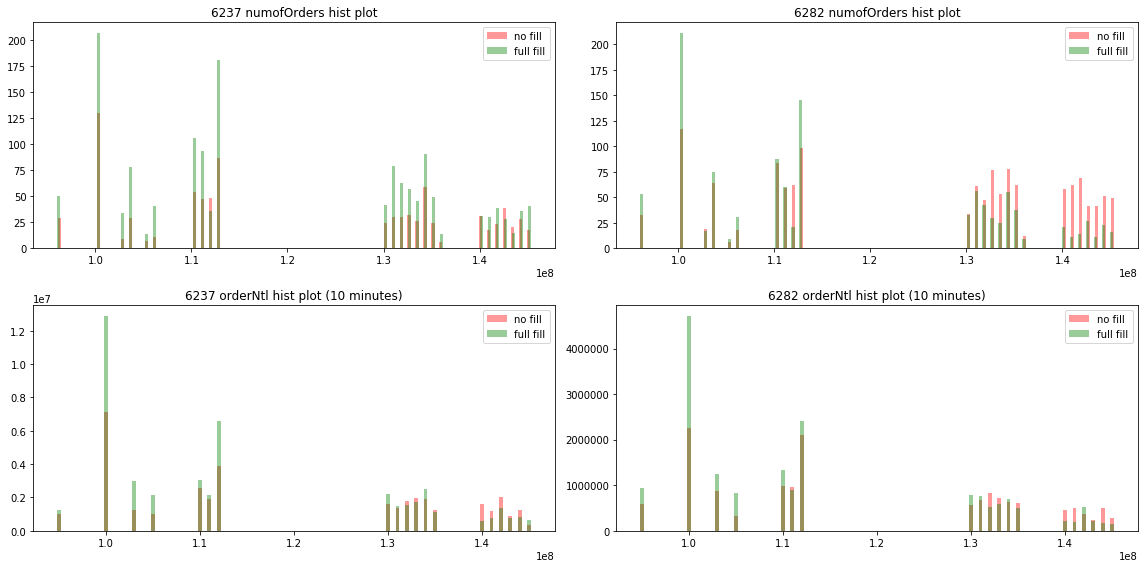

In [193]:
fig = plt.figure(figsize=(16, 8))
ax1 = fig.add_subplot(221)
a = orderLog[(orderLog['fillStatus'] == 'noFill') & (orderLog['updateType'] == 0)]
ax1.hist(a[a['accCode'] == 6237]['sdd'], bins=60, rwidth=0.4, alpha=0.4, color='red', label='no fill')
b = orderLog[(orderLog['fillStatus'] == 'fullFill') & (orderLog['updateType'] == 0)]
ax1.hist(b[b['accCode'] == 6237]['sdd'], bins=60, rwidth=0.4, alpha=0.4, color='green', label='full fill')
ax1.set_title('6237 numofOrders hist plot')
ax1.legend()

ax2 = fig.add_subplot(222)
a = orderLog[(orderLog['fillStatus'] == 'noFill') & (orderLog['updateType'] == 0)]
ax2.hist(a[a['accCode'] == 6282]['sdd'], bins=60, rwidth=0.4, alpha=0.4, color='red', label='no fill')
b = orderLog[(orderLog['fillStatus'] == 'fullFill') & (orderLog['updateType'] == 0)]
ax2.hist(b[b['accCode'] == 6282]['sdd'], bins=60, rwidth=0.4, alpha=0.4, color='green', label='full fill')
ax2.set_title('6282 numofOrders hist plot')
ax2.legend()

ax3 = fig.add_subplot(223)
orderLog['sdd1'] = (orderLog['sdd'] //1000000) *1000000
a = orderLog[(orderLog['fillStatus'] == 'noFill') & (orderLog['updateType'] == 0) & (orderLog['accCode'] == 6237)]
a = a.groupby('sdd1')['orderNtl'].sum().reset_index()
ax3.bar(a['sdd1'].values, a['orderNtl'].values, width=400000, color='red', alpha=0.4, label='no fill')
b = orderLog[(orderLog['fillStatus'] == 'fullFill') & (orderLog['updateType'] == 0) & (orderLog['accCode'] == 6237)]
b = b.groupby('sdd1')['orderNtl'].sum().reset_index()
ax3.bar(b['sdd1'].values, b['orderNtl'].values, width=400000, color='green', alpha=0.4, label='full fill')
ax3.set_title('6237 orderNtl hist plot (10 minutes)')
ax3.legend()

ax4 = fig.add_subplot(224)
orderLog['sdd1'] = (orderLog['sdd'] //1000000) *1000000
a = orderLog[(orderLog['fillStatus'] == 'noFill') & (orderLog['updateType'] == 0) & (orderLog['accCode'] == 6282)]
a = a.groupby('sdd1')['orderNtl'].sum().reset_index()
ax4.bar(a['sdd1'].values, a['orderNtl'].values, width=400000, color='red', alpha=0.4, label='no fill')
b = orderLog[(orderLog['fillStatus'] == 'fullFill') & (orderLog['updateType'] == 0) & (orderLog['accCode'] == 6282)]
b = b.groupby('sdd1')['orderNtl'].sum().reset_index()
ax4.bar(b['sdd1'].values, b['orderNtl'].values, width=400000, color='green', alpha=0.4, label='full fill')
ax4.set_title('6282 orderNtl hist plot (10 minutes)')
ax4.legend()
fig.tight_layout()
plt.show()


(array([ 53.,   0.,   0.,   0.,   0., 211.,   0.,   0.,  17.,  75.,   0.,
          9.,  31.,   0.,   0.,   0.,   0.,  88.,  60.,  21., 145.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,  33.,  56.,  42.,
         30.,  25.,  55.,  37.,   9.,   0.,   0.,   0.,   0.,  21.,  11.,
         14.,  27.,  11.,  23.,  16.]),
 array([9.57519900e+07, 9.65817610e+07, 9.74115320e+07, 9.82413030e+07,
        9.90710740e+07, 9.99008450e+07, 1.00730616e+08, 1.01560387e+08,
        1.02390158e+08, 1.03219929e+08, 1.04049700e+08, 1.04879471e+08,
        1.05709242e+08, 1.06539013e+08, 1.07368784e+08, 1.08198555e+08,
        1.09028326e+08, 1.09858097e+08, 1.10687868e+08, 1.11517639e+08,
        1.12347410e+08, 1.13177181e+08, 1.14006952e+08, 1.14836723e+08,
        1.15666494e+08, 1.16496265e+08, 1.17326036e+08, 1.18155807e+08,
        1.18985578e+08, 1.19815349e+08, 1.20645120e+08, 1.21474891e+08,
        1.2230

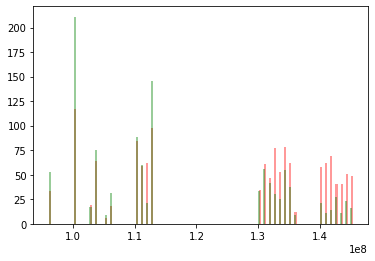

In [87]:
a = orderLog[(orderLog['fillStatus'] == 'noFill') & (orderLog['updateType'] == 0)]
plt.hist(a[a['accCode'] == 6282]['sdd'], bins=60, rwidth=0.4, alpha=0.4, color='red')
b = orderLog[(orderLog['fillStatus'] == 'fullFill') & (orderLog['updateType'] == 0)]
plt.hist(b[b['accCode'] == 6282]['sdd'], bins=60, rwidth=0.4, alpha=0.4, color='green')

In [155]:
orderLog['sdd1'] = (orderLog['sdd'] //100000) * 100000

,sdd1,orderNtl
0,95800000.0,774045.08
1,95900000.0,208625.00
2,100000000.0,4811146.60
3,100100000.0,1680388.00
4,100200000.0,437353.00
5,100300000.0,124929.00
6,100400000.0,48856.00
7,100500000.0,11296.00
8,103000000.0,48960.00
9,103100000.0,165462.20


<BarContainer object of 19 artists>

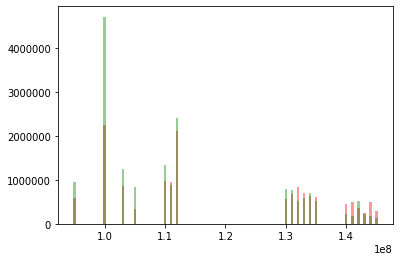

In [179]:
import matplotlib.pyplot as plt
orderLog['sdd1'] = (orderLog['sdd'] //1000000) *1000000
a = orderLog[(orderLog['fillStatus'] == 'noFill') & (orderLog['updateType'] == 0) & (orderLog['accCode'] == 6282)]
a = a.groupby('sdd1')['orderNtl'].sum().reset_index()
plt.bar(a['sdd1'].astype('int64').values, a['orderNtl'].astype('int64').values, width=400000, color='red', alpha=0.4)
b = orderLog[(orderLog['fillStatus'] == 'fullFill') & (orderLog['updateType'] == 0) & (orderLog['accCode'] == 6282)]
b = b.groupby('sdd1')['orderNtl'].sum().reset_index()
plt.bar(b['sdd1'].astype('int64').values, b['orderNtl'].astype('int64').values, width=400000, color='green', alpha=0.4)

In [170]:
(orderLog['sdd'].iloc[0] //1000000) *100000

13500000.0

In [146]:
 orderLog[(orderLog['fillStatus'] == 'noFill') & (orderLog['updateType'] == 0) & (orderLog['accCode'] == 6237)]['orderNtl'].max()

354640.0

In [147]:
orderLog[(orderLog['fillStatus'] == 'noFill') & (orderLog['updateType'] == 0) & (orderLog['accCode'] == 6282)]['orderNtl'].max()

149760.0

<BarContainer object of 1732 artists>

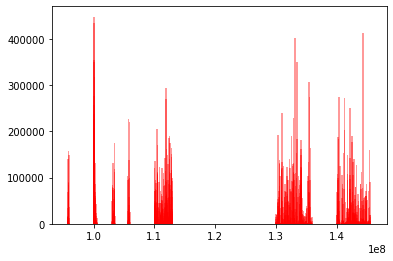

In [138]:
plt.bar(a['sdd'].astype('int64').values, a['orderNtl'].astype('int64').values, width=250000, color='red', alpha=0.4)

In [121]:
a['orderNtl'].astype('int64').values[:10]

array([  2751,   1232,  15050,  68349,   1462,   5104,  12305,  17820,
         6281, 140455], dtype=int64)

In [116]:
a['sdd'].values[:10]

array([95751000., 95754630., 95801170., 95805550., 95807360., 95807510.,
       95810730., 95812430., 95814730., 95814980.])

In [ ]:
a = orderLog[(orderLog['fillStatus'] == 'noFill') & (orderLog['updateType'] == 0)]
plt.hist(a[a['accCode'] == 6282]['sdd'], bins=60, rwidth=0.4, alpha=0.4, color='red')
b = orderLog[(orderLog['fillStatus'] == 'fullFill') & (orderLog['updateType'] == 0)]
plt.hist(b[b['accCode'] == 6282]['sdd'], bins=60, rwidth=0.4, alpha=0.4, color='green')

In [68]:
p2 = checkLog.groupby(['accCode', 'm/a'])['date'].count().reset_index()
p2 = pd.pivot_table(p2,index=['accCode'],columns=['m/a'],values=['date'])
p = pd.merge(p1, p2, on ='accCode')
p = p.iloc[:, [3, 1, 2, 0]]
p['colo', 'morning %'] = p['date', 'morning'] / p['colo', 'morning']
p['colo', 'morning %'] = p['colo', 'morning %'].apply(lambda x: '%.1f%%'%(100*x))
p['date', 'afternoon %'] = p['date', 'afternoon'] / p['colo', 'afternoon']
p['date', 'afternoon %'] = p['date', 'afternoon %'].apply(lambda x: '%.1f%%'%(100*x))
p = p.iloc[:, [0,1,4,2,3,5]]
p

date    colo                date      colo        date
m/a     morning morning morning % afternoon afternoon afternoon %
accCode                                                          
6237        512     929     55.1%       419       715       58.6%
6282        506     937     54.0%       309       869       35.6%

In [72]:
orderLog['sdd'] = orderLog.groupby('order')['sdd'].transform('max')
orderLog['m/a'] = np.where(orderLog['sdd'] < 130000000, '1. morning', '2. afternoon')

In [73]:
test = orderLog
test['trade_size'] = test.groupby('order')['absFilledThisUpdate'].transform('sum')
test['trade_status'] = np.where(test['absOrderSize'] ==test['trade_size'], 1, 0)
k1 = test[test['updateType'] == 0].groupby(['exchange', 'm/a', 'accCode'])['trade_status'].sum().reset_index()
k1 = k1.rename(columns={'trade_status':"num_of_fullfilled_orders"})
k2 = test[test['updateType'] == 0].groupby(['exchange', 'm/a', 'accCode'])['trade_status'].size().reset_index()
k2 = k2.rename(columns={'trade_status':"num_of_total_orders"})
k = pd.merge(k1, k2, on=['exchange', 'accCode', 'm/a'])
k['full filled%'] = (k['num_of_fullfilled_orders']/ k['num_of_total_orders']).apply(lambda x: '%.1f%%'%(100*x))
test['trade_status'] = np.where((test['absOrderSize'] > test['trade_size']) & (test['trade_size'] != 0), 1, 0)
k1 = test[test['updateType'] == 0].groupby(['exchange', 'm/a', 'accCode'])['trade_status'].sum().reset_index()
k1 = k1.rename(columns={'trade_status':"num_of_partialfilled_orders"})
k2 = test[test['updateType'] == 0].groupby(['exchange', 'm/a', 'accCode'])['trade_status'].size().reset_index()
k2 = k2.rename(columns={'trade_status':"num_of_total_orders"})
kk = pd.merge(k1, k2, on=['exchange', 'accCode', 'm/a'])
kk['partial filled%'] = (kk['num_of_partialfilled_orders']/ kk['num_of_total_orders']).apply(lambda x: '%.1f%%'%(100*x))
k = pd.merge(k, kk, on = ['exchange', 'accCode', 'm/a'])
test['trade_status'] = np.where((test['trade_size'] == 0), 1, 0)
k1 = test[test['updateType'] == 0].groupby(['exchange', 'm/a', 'accCode'])['trade_status'].sum().reset_index()
k1 = k1.rename(columns={'trade_status':"num_of_nofilled_orders"})
k2 = test[test['updateType'] == 0].groupby(['exchange', 'm/a', 'accCode'])['trade_status'].size().reset_index()
k2 = k2.rename(columns={'trade_status':"num_of_total_orders"})
kk = pd.merge(k1, k2, on=['exchange', 'accCode', 'm/a'])
kk['no filled%'] = (kk['num_of_nofilled_orders']/ kk['num_of_total_orders']).apply(lambda x: '%.1f%%'%(100*x))
k = pd.merge(k, kk, on = ['exchange', 'accCode', 'm/a'])
from IPython.display import display, HTML
HTML(k.groupby(['exchange', 'm/a', 'accCode'])['full filled%', 'partial filled%', 'no filled%', 'num_of_total_orders'].first().to_html())

In [27]:
ol = orderLog[orderLog['updateType'] == 3]['order'].unique()
orderLog1 = orderLog[orderLog['order'].isin(ol)]
re1 = orderLog1[orderLog1['updateType'] == 3].groupby(['accCode'])['duration'].describe().astype('int64').reset_index()
c1 = orderLog1[orderLog1['updateType'] == 3].groupby(['accCode'])['duration'].apply(lambda x: x.describe([0.1])['10%']).astype(int).reset_index()
c1 = c1.rename(columns={"duration":"10%"})
re1 = pd.merge(re1, c1[['accCode', '10%']], on=['accCode'])
c1 = orderLog1[orderLog1['updateType'] == 3].groupby(['accCode'])['duration'].apply(lambda x: x.describe([0.9])['90%']).astype(int).reset_index()
c1 = c1.rename(columns={"duration":"90%"})
re1 = pd.merge(re1, c1[['accCode', '90%']], on=['accCode'])
re1['accCode'] = re1['accCode'].astype(int)
display(HTML(re1[['accCode', 'count',  'min', '10%', '25%', '50%', '75%', '90%', 'max']].groupby(['accCode']).first().to_html()))

,count,min,10%,25%,50%,75%,90%,max
accCode,,,,,,,,
6237,982,1060342,1447349,2065577,3249656,5128449,9996638,422370759
6282,1433,1058382,1350054,2075729,4195856,13247844,50293834,10334916069


In [55]:
orderLog['sdd'] = orderLog.groupby('order')['sdd'].transform('max')
orderLog['m/a'] = np.where(orderLog['sdd'] < 130000000, 'morning', 'afternoon')
p1 = orderLog[(orderLog['updateType'] == 0) & (orderLog['exchange'] == 'SZE')].groupby(['accCode', 'm/a'])['colo'].size().reset_index()
p1 = pd.pivot_table(p1,index=['accCode'],columns=['m/a'],values=['colo'])
p1

colo        
m/a     afternoon morning
accCode                  
6237          715     929
6282          869     937

In [21]:
orderLog['trade_size'] = orderLog.groupby('order')['absFilledThisUpdate'].transform('sum')
orderLog['trade_status'] = np.where(orderLog['absOrderSize'] ==orderLog['trade_size'], 1, 0)
k1 = orderLog[orderLog['updateType'] == 0].groupby(['exchange', 'accCode'])['trade_status'].sum().reset_index()
k1 = k1.rename(columns={'trade_status':"num_of_fullfilled_orders"})
k2 = orderLog[orderLog['updateType'] == 0].groupby(['exchange', 'accCode'])['trade_status'].size().reset_index()
k2 = k2.rename(columns={'trade_status':"num_of_total_orders"})
k = pd.merge(k1, k2, on=['exchange', 'accCode'])
k['full filled%'] = (k['num_of_fullfilled_orders']/ k['num_of_total_orders']).apply(lambda x: '%.1f%%'%(100*x))
orderLog['trade_status'] = np.where((orderLog['absOrderSize'] > orderLog['trade_size']) & (orderLog['trade_size'] != 0), 1, 0)
k1 = orderLog[orderLog['updateType'] == 0].groupby(['exchange', 'accCode'])['trade_status'].sum().reset_index()
k1 = k1.rename(columns={'trade_status':"num_of_partialfilled_orders"})
k2 = orderLog[orderLog['updateType'] == 0].groupby(['exchange', 'accCode'])['trade_status'].size().reset_index()
k2 = k2.rename(columns={'trade_status':"num_of_total_orders"})
kk = pd.merge(k1, k2, on=['exchange', 'accCode'])
kk['partial filled%'] = (kk['num_of_partialfilled_orders']/ kk['num_of_total_orders']).apply(lambda x: '%.1f%%'%(100*x))
k = pd.merge(k, kk, on = ['exchange', 'accCode'])
orderLog['trade_status'] = np.where((orderLog['trade_size'] == 0), 1, 0)
k1 = orderLog[orderLog['updateType'] == 0].groupby(['exchange', 'accCode'])['trade_status'].sum().reset_index()
k1 = k1.rename(columns={'trade_status':"num_of_nofilled_orders"})
k2 = orderLog[orderLog['updateType'] == 0].groupby(['exchange', 'accCode'])['trade_status'].size().reset_index()
k2 = k2.rename(columns={'trade_status':"num_of_total_orders"})
kk = pd.merge(k1, k2, on=['exchange', 'accCode'])
kk['no filled%'] = (kk['num_of_nofilled_orders']/ kk['num_of_total_orders']).apply(lambda x: '%.1f%%'%(100*x))
k = pd.merge(k, kk, on = ['exchange', 'accCode'])
from IPython.display import display, HTML
HTML(k.groupby(['exchange', 'accCode'])['full filled%', 'partial filled%', 'no filled%'].first().to_html())

In [76]:
orderLog['sta'] = np.where(orderLog['ars'].isin([121, 221, 321, 131, 231, 331]), 'statwo', 'staone')
re1 = orderLog[(orderLog['updateType'] == 0)].groupby(['exchange','m/a', 'accCode'])['orderNtl'].sum().reset_index()
re2 = orderLog[(orderLog['updateType'] == 4)].groupby(['exchange','m/a', 'accCode'])['tradeNtl'].sum().reset_index()
re = pd.merge(re1, re2, on=['exchange','m/a','accCode'])
re['fill_rate'] = re['tradeNtl'] / re['orderNtl']
re['fill_rate'] = re['fill_rate'].apply(lambda x: '%.1f%%'%(100*x))
re['orderNtl'] = re['orderNtl'].astype('int64')
re['tradeNtl'] = re['tradeNtl'].astype('int64')
from IPython.display import display, HTML
HTML(re.groupby(['exchange', 'm/a','accCode']).first().to_html())

In [9]:
re2

,sta,isMsg,colo,accCode,tradeNtl
0,staone,1.0,zs_94_04,6237,30481117.57
1,staone,1.0,zs_96_08,6282,12566599.72


In [7]:
orderLog[(orderLog['exchange'] == 'SZE') & (orderLog['updateType'] == 0)]['isMsg'].unique()

array([1., 0.])

In [6]:
orderLog[(orderLog['updateType'] == 0) & (orderLog['accCode'].isin([6237, 6282]))].groupby(['exchange', 'colo', 'accCode', 'date', 'ars'])['isMsg'].unique()

exchange  colo      accCode  date      ars 
SSE       zs_94_04  6237     20200813  11.0    [0.0, 1.0]
          zs_96_08  6282     20200813  11.0    [0.0, 1.0]
SZE       zs_94_04  6237     20200813  11.0    [1.0, 0.0]
          zs_96_08  6282     20200813  11.0    [1.0, 0.0]
Name: isMsg, dtype: object

In [41]:
orderLog = orderLog[orderLog['accCode'].isin([6237, 6282])]
orderLog["server"] = orderLog["colo"].apply(lambda x: x.split("_")[0] + x.split("_")[1] + x.split("_")[2])
orderLog["server_account"] = orderLog["server"] + '_' + orderLog['accCode'].astype('str')
checkLog = orderLog[orderLog['updateType'].isin([0, 3, 4])].reset_index(drop=True)
checkLog = checkLog[checkLog['duration'] <= 3e6]

checkLog["time"] = checkLog["clock"].apply(lambda x: x.strftime("%H%M%S")).astype(int)

checkLog['accountNum'] = checkLog.groupby(['date', 'secid', 'vai', 'isMsg'])['server_account'].transform('nunique')
checkLog = checkLog[checkLog['accountNum'] >= 2]
checkLog['cumFillSize'] = checkLog.groupby(['order'])['absOrderSizeCumFilled'].transform('max')
checkLog['status'] = np.where(checkLog['cumFillSize'] == 0, 2, 
                                np.where(checkLog['cumFillSize'] < checkLog['absOrderSize'], 1, 0))
checkLog = checkLog.groupby(['group', 'order'])[['date', 'server_account', 'secid', 'vai', 'status', 'isMsg']].first().reset_index()

for exchg in ['SSE']:
    
    print(exchg)
    
    if exchg == 'SSE':
        exchangeLog = checkLog[checkLog['secid'] < 2000000]
    else:
        exchangeLog = checkLog[checkLog['secid'] >= 2000000]
    
    result = {}
    for col in ['date', 'isMsg', 'broker1', 'broker2', 'isFast']:
        result[col] = []

    for group, groupData in exchangeLog.groupby(['group']):
        date = groupData['date'].values[0]
        brokerLs = groupData['server_account'].values
        if len(brokerLs) == 0:
            continue
        statusLs = groupData['status'].values
        ixLs = [i for i in range(len(brokerLs))]
        for k, broker1, status1 in zip(ixLs[:-1], brokerLs[:-1], statusLs[:-1]):
            for broker2, status2 in zip(brokerLs[k+1:], statusLs[k+1:]):
                if broker1 != broker2:
                    result['date'] += [date, date]
                    result['isMsg'] += [groupData['isMsg'].values[0], groupData['isMsg'].values[0]]
                    result['broker1'] += [broker1, broker2]
                    result['broker2'] += [broker2, broker1]

                    if status1 < status2:
                        result['isFast'] += [1, 0]
                    elif status1 > status2:
                        result['isFast'] += [0, 1]
                    else:
                        result['isFast'] += [-1, -1]                

    result = pd.DataFrame(result)
    result = result[result['isFast'] != -1]
    result['count'] = result.groupby(['broker1', 'broker2'])['isFast'].transform('count')
    result['fasterSum'] = result.groupby(['broker1', 'broker2'])['isFast'].transform('sum')
    result['faster'] = result['fasterSum']/result['count']

    
    summary = pd.DataFrame()
    summaryCols = []
    countCols = []
    fasterCols = []
    for date in result['date'].unique():
        a = result[result['date'] == date].reset_index(drop=True)
        a['count'] = a.groupby(['broker1', 'broker2'])['isFast'].transform('count')
        a['fasterSum'] = a.groupby(['broker1', 'broker2'])['isFast'].transform('sum')
        a['faster'] = a['fasterSum']/a['count']
        a = a.groupby(['broker1', 'broker2'])[['count', 'faster']].mean().reset_index()
        a.columns = ['broker1', 'broker2', '%s count'%date, '%s faster'%date]
        summaryCols += ['%s count'%date, '%s faster'%date]
        countCols += ['%s count'%date]
        fasterCols += ['%s faster'%date]
        
        if summary.empty:
            summary = a.copy()
        else:
            summary = pd.merge(summary, a, how='outer', on=['broker1', 'broker2'], validate='one_to_one')
    
    a = result.groupby(['broker1', 'broker2'])[['count', 'faster']].mean().reset_index()
    a.columns = ['broker1', 'broker2', 'total count', 'total faster']
    summary = pd.merge(summary, a, how='outer', on=['broker1', 'broker2'], validate='one_to_one')
    summaryCols = ['total count', 'total faster'] + summaryCols
    
    
    savePath = r'L:\orderLog\result\relativeSpeed'
    a = summary.groupby(['broker1', 'broker2'])[['total count', 'total faster']].first().reset_index()



    
    countCols += ['total count']
    fasterCols += ['total faster']
#     summary['b1'] = summary['broker1'].str[7:11].astype(int) // 100
#     summary['b2'] = summary['broker2'].str[7:11].astype(int) // 100
#     summary = summary.groupby(['broker1', 'broker2'])[summaryCols].first()
    for col in countCols:
        summary[col] = summary[col].fillna(0)
        summary[col] = summary[col].astype('int64')
        
    for col in fasterCols:
        summary[col] = summary[col].fillna(-1)
        summary[col] = summary[col].apply(lambda x: '%.0f%%'%(x*100))
        summary[col] = np.where(summary[col] == '-100%', ' ', summary[col])
    
    summary["tt"]=summary[["broker1", "broker2"]].min(axis=1).astype(str) + ' - ' + summary[["broker1", "broker2"]].max(axis=1).astype(str)
    summary = summary.sort_values(by=["tt", "broker1"])
    s1 = summary.groupby("tt").first().reset_index(drop=True)
    display(s1)

SSE


,broker1,broker2,20200813 count,20200813 faster,total count,total faster
0,zs9404_6237,zs9608_6282,63,60%,63,60%


In [15]:
checkLog[(checkLog['secid'] < 2000000) & (checkLog['num'] == 2)].drop_duplicates(['vai']).groupby(['isMsg'])['vai'].size()

isMsg
0.0    49
1.0    13
Name: vai, dtype: int64

In [14]:
checkLog['num'] = checkLog.groupby(['vai'])['status'].transform('nunique')

In [28]:
checkLog[(checkLog['secid'] > 2000000)].groupby('status')['vai'].size()

status
0     642
1     120
2    1034
Name: vai, dtype: int64

In [32]:
orderLog[(orderLog['secid'] < 2000000) & (orderLog['updateType'] == 4)]['duration'].describe([0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 0.95, 0.99]).astype('int64')

count         1655
mean       3427193
std        8791481
min          93530
10%         470707
20%         518364
30%         561481
40%         640906
50%         784229
60%         945930
70%        1704446
80%        2929010
90%        7312712
95%       16444500
99%       39533360
max      115273049
Name: duration, dtype: int64

In [29]:
def getTuple(x):
    return tuple(i for i in x)

c1 = orderLog[~((orderLog['updateType'] == 4) & (orderLog.groupby(['order'])['updateType'].shift(-1) == 4)) & (orderLog['ars'] == 11)]
c1 = c1.groupby(['order'])['updateType'].apply(lambda x: getTuple(x)).reset_index()
c1.groupby('updateType')['order'].size().sort_values()

updateType
(0, 4, 2, 1, 3)          1
(0, 2, 4, 1, 4, 3)       4
(0, 4, 2, 4)             7
(0, 4)                  13
(0, 2, 4, 1, 4)         21
(0, 2, 1, 4, 3)         25
(0, 2, 4, 1, 3)         84
(0, 2, 1, 4)           179
(0, 2, 1, 3)           964
(0, 2, 4)             2277
Name: order, dtype: int64

In [80]:
orderLog[(orderLog['updateType'] == 4) & (orderLog['ars'] == 11) & (orderLog['accCode'] == 6237)]['duration'].describe([0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 0.95, 0.99]).astype('int64')

count         3333
mean       6049730
std       28968112
min          53557
10%          79346
20%         147071
30%         280636
40%         442894
50%         597563
60%         948407
70%        1984068
80%        3855098
90%       10479157
95%       21564429
99%       85537943
max      457649491
Name: duration, dtype: int64

In [81]:
orderLog[(orderLog['updateType'] == 4) & (orderLog['ars'] == 11) & (orderLog['accCode'] == 6282)]['duration'].describe([0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 0.95, 0.99]).astype('int64')

count        1121
mean      2920099
std       3871813
min         77076
10%        149268
20%        345156
30%        633899
40%        961194
50%       1362573
60%       2080414
70%       2921876
80%       4573217
90%       8757101
95%      10498070
99%      15647816
max      35712846
Name: duration, dtype: int64

In [2]:
startTm = datetime.datetime.now()

# readPath = r'\\192.168.10.30\Kevin_zhenyu\orderLog\equityTradeLogs'
# dataPathLs = np.array(glob.glob(os.path.join(readPath, 'speedCompare***.csv')))
# dateLs = np.array([os.path.basename(i).split('_')[1].split('.')[0] for i in dataPathLs])
# dataPathLs = dataPathLs[(dateLs >= startDate) & (dateLs <= endDate)]
# dateLs = dateLs[(dateLs >= startDate) & (dateLs <= endDate)]
dateLs = ['20200907']

for date in dateLs:
        
#     readPath = r'\\192.168.10.30\Kevin_zhenyu\orderLog\equityTradeLogs'
#     orderLog = pd.read_csv(os.path.join(readPath, 'speedCompare_%s.csv'%date))
    orderLog = pd.read_pickle(r'A:\temp\speedCheck\zs66_20200907_20200908.pkl')
    orderLog = orderLog[orderLog['date'] == int(date)]
    orderLog = orderLog.fillna(0)
    
    for col in ['clockAtArrival', 'secid', 'updateType', 'vai', 'absFilledThisUpdate', 'orderDirection', 'absOrderSize',
                'absOrderSizeCumFilled', 'date', 'accCode', 'mse']:
        orderLog[col] = orderLog[col].astype('int64')
    
    orderLog = orderLog.sort_values(by=['date', 'secid', 'vai', 'accCode', 'clockAtArrival']).reset_index(drop=True)
    orderLog = orderLog[orderLog["secid"] >= 1000000]
    orderLog['order'] = orderLog.groupby(['date', 'accCode', 'secid', 'vai']).grouper.group_info[0]
    orderLog["ars"] = orderLog.groupby(['order'])['ars'].transform('first')

    targetStock = orderLog['secid'].unique()
    targetStock = np.array([int(str(i)[1:]) for i in targetStock])
    targetStockSZ = sorted(targetStock[targetStock < 600000])
    targetStockSH = sorted(targetStock[targetStock >= 600000])
        
    readPath = 'A:\\rawData'
    mdOrderLogPath = glob.glob(os.path.join(readPath, 'logs_%s_zs_92_01***'%date, 'mdOrderLog***.csv'))[-1]
    mdTradeLogPath = glob.glob(os.path.join(readPath, 'logs_%s_zs_92_01***'%date, 'mdTradeLog***.csv'))[-1]
    
    mdOrderLog = pd.read_csv(mdOrderLogPath)
    mdOrderLog = mdOrderLog[mdOrderLog['SecurityID'].isin(targetStockSZ)]
    mdOrderLog['OrderType'] = mdOrderLog['OrderType'].astype(str)
    mdOrderLog = mdOrderLog[['clockAtArrival', 'sequenceNo', 'TransactTime', 'SecurityID', 'ApplSeqNum', 'Side',
                             'OrderType', 'Price', 'OrderQty']]
    
    mdTradeLog = pd.read_csv(mdTradeLogPath)
    mdTradeLog['ExecType'] = mdTradeLog['ExecType'].astype(str)
    mdTradeLog = mdTradeLog[mdTradeLog['SecurityID'].isin(targetStockSZ)]
    mdTradeLog['volumeThisUpdate'] = np.where(mdTradeLog['ExecType'] == 'F', mdTradeLog['TradeQty'], 0)
    mdTradeLog['cum_volume'] = mdTradeLog.groupby(['SecurityID'])['volumeThisUpdate'].cumsum()
    mdTradeLog = mdTradeLog[['clockAtArrival', 'sequenceNo', 'TransactTime', 'SecurityID', 'ApplSeqNum', 'cum_volume',
                             'ExecType', 'TradePrice', 'TradeQty', 'TradeMoney', 'BidApplSeqNum', 'OfferApplSeqNum']]

    mdMsgData = pd.concat([mdOrderLog, mdTradeLog], sort=False)
    del mdOrderLog
    del mdTradeLog
    
    mdMsgData = mdMsgData.sort_values(by=['sequenceNo']).reset_index(drop=True)
    
    mdMsgData["agg_trade"] = np.where((mdMsgData["ApplSeqNum"] == mdMsgData["BidApplSeqNum"] + 1) & (mdMsgData["ExecType"] == "F"), 1, np.where(
    (mdMsgData["ApplSeqNum"] == mdMsgData["OfferApplSeqNum"] + 1) & (mdMsgData["ExecType"] == "F"), 1, 0))
    mdMsgData["agg"] = mdMsgData.groupby(["SecurityID"])["agg_trade"].shift(-1)
    mdMsgData["orderNum"] = np.where(mdMsgData["ExecType"].isnull(), 1, 0)
    mdMsgData["cumorderNum"] = mdMsgData.groupby("SecurityID")["orderNum"].cumsum()
    mdMsgData["cumorderNum2"] = np.nan
    mdMsgData.loc[mdMsgData["agg"]==1, "cumorderNum2"] = mdMsgData.loc[mdMsgData["agg"]==1, "cumorderNum"]
    mdMsgData["cumorderNum2"] = mdMsgData.groupby("SecurityID")["cumorderNum2"].ffill()
    mdMsgData.loc[mdMsgData["cumorderNum2"] == mdMsgData["cumorderNum"], "cum_volume"] = mdMsgData[mdMsgData["cumorderNum2"] == mdMsgData["cumorderNum"]]\
    .groupby(["SecurityID", "cumorderNum"])["cum_volume"].transform("max")
    
    mdMsgData = mdMsgData.sort_values(by=['sequenceNo']).reset_index(drop=True)

    mdMsgData['cum_volume'] = mdMsgData.groupby(['SecurityID'])['cum_volume'].ffill()
    mdMsgData['cum_volume'] = mdMsgData.groupby(['SecurityID'])['cum_volume'].backfill()
    mdMsgData['ExecType'] = mdMsgData['ExecType'].fillna('2')
    mdMsgData['TradeQty'] = mdMsgData['TradeQty'].fillna(0)
    
    saveCols = ['clockAtArrival', 'sequenceNo', 'TransactTime', 'SecurityID', 'cum_volume', 'ApplSeqNum', 
                'Side', 'OrderType', 'Price', 'OrderQty', 'ExecType', 'TradePrice', 'TradeQty', 'TradeMoney',
                'BidApplSeqNum', 'OfferApplSeqNum', "agg"]
    mdMsgData = mdMsgData[saveCols]
    savePath = r'L:\orderLog\mdData'
    mdMsgData.to_pickle(os.path.join(savePath, 'mdLog62_msg_%s.pkl'%date))
    
print(datetime.datetime.now() - startTm)

C:\Users\win\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3058: DtypeWarning: Columns (12) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)
C:\Users\win\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3058: DtypeWarning: Columns (11) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


0:08:18.815076


In [3]:
startTm = datetime.datetime.now()

# readPath = r'\\192.168.10.30\Kevin_zhenyu\orderLog\equityTradeLogs'
# dataPathLs = np.array(glob.glob(os.path.join(readPath, 'speedCompare***.csv')))
# dateLs = np.array([os.path.basename(i).split('_')[1].split('.')[0] for i in dataPathLs])
# dataPathLs = dataPathLs[(dateLs >= startDate) & (dateLs <= endDate)]
# dateLs = dateLs[(dateLs >= startDate) & (dateLs <= endDate) & (dateLs != '20200729')]

dateLs = ['20200907']

for thisDate in dateLs:
   
#     readPath = r'\\192.168.10.30\Kevin_zhenyu\orderLog\equityTradeLogs'
#     orderLog = pd.read_csv(os.path.join(readPath, 'speedCompare_%s.csv'%thisDate))
    orderLog = pd.read_pickle(r'A:\temp\speedCheck\zs66_20200907_20200908.pkl')
    orderLog = orderLog[orderLog['date'] == int(thisDate)]
    orderLog = orderLog.fillna(0)
    for col in ['clockAtArrival', 'secid', 'updateType', 'vai', 'absFilledThisUpdate', 'orderDirection', 'absOrderSize',
                'absOrderSizeCumFilled', 'date', 'accCode', 'mse']:
        orderLog[col] = orderLog[col].astype('int64')
        
    orderLog = orderLog.sort_values(by=['date', 'secid', 'vai', 'accCode', 'clockAtArrival']).reset_index(drop=True)
    orderLog = orderLog[orderLog["secid"] >= 1000000]

    orderLog['clock'] = orderLog['clockAtArrival'].apply(lambda x: datetime.datetime.fromtimestamp(x/1e6))
    orderLog['broker'] = orderLog['accCode'] // 100
    orderLog['colo_account'] = orderLog['colo'].str[:2] + '_' + orderLog['accCode'].astype('str')
    orderLog['order'] = orderLog.groupby(['date', 'accCode', 'secid', 'vai']).grouper.group_info[0]
    orderLog['group'] = orderLog.groupby(['date', 'secid', 'vai']).grouper.group_info[0]
    orderLog['startClock'] = orderLog.groupby(['order'])['clockAtArrival'].transform('first')
    orderLog['duration'] = orderLog['clockAtArrival'] - orderLog['startClock']
    orderLog['orderPrice'] = orderLog['orderPrice'].apply(lambda x: round(x, 2))
    orderLog['tradePrice'] = orderLog['tradePrice'].apply(lambda x: round(x, 2))
    orderLog['orderDirection1'] = np.where(orderLog["orderDirection"] == -2, -1, np.where(
    orderLog["orderDirection"] == 2, 1, orderLog["orderDirection"]))
    display("Different orderDirection type:")
    display(orderLog["orderDirection"].unique())
    display(orderLog["orderDirection1"].unique())
    orderLog = orderLog.copy()

    ### make sure no order has shares > 80w or notional > 800w
    orderLog['orderNtl'] = orderLog['absOrderSize'] * orderLog['orderPrice']

    ### make sure same direction in same colo_broker
    orderLog['directNum'] = orderLog.groupby(['date', 'secid', 'vai'])['orderDirection1'].transform('nunique')
    if len(orderLog[orderLog['directNum'] != 1]) > 0:
        orderLog = orderLog[orderLog['directNum'] == 1]

    assert((orderLog.groupby(['date', 'secid', 'vai'])['orderDirection1'].nunique() == 1).all() == True)

    ## make sure each account, secid, vai only has one insertion
    a = orderLog[orderLog['updateType'] == 0].groupby(['date', 'accCode', 'secid', 'vai', 'order'])['clockAtArrival'].count()
    if len(a[a > 1]) > 0:
        a = a[a>1].reset_index()
        orderLog = orderLog[~(orderLog['order'].isin(a['order'].unique()))]

    orderLog['isMsg'] = np.where(orderLog['updateType'] == 0, 
                                 np.where(orderLog['mse'] == 100, 1, 0), np.nan)
    orderLog['isMsg'] = orderLog.groupby(['order'])['isMsg'].ffill()
    placeSZE = orderLog[(orderLog['secid'] >= 2000000) & (orderLog['updateType'] == 0)]

    ### make sure there is no unexpected updateType 
    def getTuple(x):
        return tuple(i for i in x)

    checkLog = orderLog[~((orderLog['updateType'] == 4) & (orderLog.groupby(['order'])['updateType'].shift(-1) == 4))]
    checkLog = checkLog.groupby(['order'])['updateType'].apply(lambda x: getTuple(x)).reset_index()
    checkLog['status'] = np.where(checkLog['updateType'].isin([(0, 2, 4), (0, 2, 2, 4), (0, 2, 2, 1, 4), (0, 2, 1, 4), (0, 2, 1, 2, 4), (0, 2, 4, 1, 4), (0, 4), (0, 4, 1, 4), (0, 2, 2, 4, 1, 4), (0, 4, 2, 4)]),0,
                     np.where(checkLog['updateType'].isin([(0, 2, 4, 1, 3), (0, 2, 4, 1, 4, 3), (0, 2, 1, 4, 3), (0, 4, 1, 3), (0, 2, 2, 4, 1, 4, 3), (0, 2, 2, 4, 1, 3), (0, 2, 2, 1, 4, 3), (0, 4, 2, 4, 1, 3), (0, 4, 2, 1, 3), (0, 2, 4, 2, 1, 3), (0, 4, 1, 4, 3), (0, 4, 2, 4, 1, 4, 3)]), 1,
                     np.where(checkLog['updateType'].isin([(0, 2, 1, 3), (0, 2, 2, 1, 3)]), 2,
                     np.where(checkLog['updateType'].isin([(0, 3)]), 3,
                     np.where(checkLog['updateType'].isin([(0,), (0, 2), (0, 2, 1), (0, 2, 2), (0, 2, 4, 1)]), 4, 5)))))
    display(set(checkLog["updateType"].unique()) - set([(0, 2, 4), (0, 2, 2, 4), (0, 2, 2, 1, 4), (0, 2, 1, 4), (0, 2, 1, 2, 4),
                                                    (0, 2, 4, 1, 4), (0, 4), (0, 4, 1, 4), (0, 2, 2, 4, 1, 4), (0, 4, 2, 4),
                                                    (0, 2, 4, 1, 3), (0, 2, 4, 1, 4, 3), (0, 2, 1, 4, 3), (0, 4, 1, 3),
                                                    (0, 2, 2, 4, 1, 4, 3), (0, 2, 2, 4, 1, 3), (0, 2, 2, 1, 4, 3),
                                                    (0, 4, 2, 4, 1, 3), (0, 4, 2, 1, 3), (0, 4, 2, 4, 1, 4, 3), (0, 2, 1, 3), (0, 2, 2, 1, 3),
                                                    (0, 3), (0,), (0, 2), (0, 2, 1), (0, 2, 4, 2, 1, 3), (0, 4, 1, 4, 3), 
                                                    (0, 2, 2), (0, 2, 4, 1)]))

    orderLog = pd.merge(orderLog, checkLog[['order', 'status']], how='left', on=['order'], validate='many_to_one')
    orderLog = orderLog[orderLog['status'].isin([0, 1, 2])].reset_index(drop=True)

    ### check status==0 got all traded
    a = orderLog[orderLog['status'] == 0]
    a = a.groupby(['order'])[['absOrderSizeCumFilled', 'absOrderSize']].max().reset_index()
    a.columns = ['order', 'filled', 'total']
    if a[a['filled'] != a['total']].shape[0] > 0:
        removeOrderLs = a[a['filled'] != a['total']]['order'].unique()
        orderLog = orderLog[~(orderLog['order'].isin(removeOrderLs))]

    ### check status==1 got partial traded
    a = orderLog[orderLog['status'] == 1]
    a = a.groupby(['order'])[['absOrderSizeCumFilled', 'absOrderSize']].max().reset_index()
    a.columns = ['order', 'filled', 'total']
    if a[(a['filled'] >= a['total']) | (a['filled'] == 0)].shape[0] > 0:
        removeOrderLs = a[(a['filled'] >= a['total']) | (a['filled'] == 0)]['order'].unique()
        orderLog = orderLog[~(orderLog['order'].isin(removeOrderLs))]

    ### check if any cancellation within 1 sec
    a = orderLog[(orderLog['updateType'] == 1) & (orderLog['duration'] < 1e6)]
    if a.shape[0] > 0:
        removeOrderLs = a['order'].unique()
        orderLog = orderLog[~(orderLog['order'].isin(removeOrderLs))]

    orderLog = orderLog.sort_values(by=['date', 'secid', 'vai', 'accCode', 'clockAtArrival']).reset_index(drop=True)

    orderLog['exchange'] = np.where(orderLog['secid'] >= 2000000, 'SZE', 'SSE')
    orderLog['orderNtl'] = orderLog['orderPrice'] * orderLog['absOrderSize']
    orderLog['tradeNtl'] = np.where(orderLog['updateType'] == 4, orderLog['tradePrice']*orderLog['absFilledThisUpdate'], 0)
    orderLog = orderLog[orderLog['secid'] >= 2000000].reset_index(drop=True)
    
    # 1. market orders
    readPath = r'L:\orderLog\mdData'
    rawMsgDataSZ = pd.read_pickle(os.path.join(readPath, 'mdLog62_msg_%s.pkl'%thisDate))
    orderDataSZ = rawMsgDataSZ[rawMsgDataSZ['ExecType'] == '2'][['SecurityID', 'ApplSeqNum', 'clockAtArrival', 'sequenceNo', 'Side', 'OrderQty', 'Price', 'cum_volume', "agg", "TransactTime"]].reset_index(drop=True)
    orderDataSZ['updateType'] = 0
    tradeDataSZ = pd.concat([rawMsgDataSZ[rawMsgDataSZ['ExecType'] == 'F'][['SecurityID', 'BidApplSeqNum', 'clockAtArrival', 'sequenceNo', 'TradePrice', 'TradeQty', 'cum_volume', "TransactTime"]],
                             rawMsgDataSZ[rawMsgDataSZ['ExecType'] == 'F'][['SecurityID', 'OfferApplSeqNum', 'clockAtArrival', 'sequenceNo', 'TradePrice', 'TradeQty', 'cum_volume', "TransactTime"]]], sort=False)
    tradeDataSZ['ApplSeqNum'] = np.where(tradeDataSZ['BidApplSeqNum'].isnull(), tradeDataSZ['OfferApplSeqNum'], tradeDataSZ['BidApplSeqNum'])
    tradeDataSZ['Side'] = np.where(tradeDataSZ['BidApplSeqNum'].isnull(), 2, 1)
    tradeDataSZ = tradeDataSZ[['SecurityID', 'ApplSeqNum', 'clockAtArrival', 'sequenceNo', 'Side', 'TradePrice', 'TradeQty', 'cum_volume', "TransactTime"]]
    tradeDataSZ['updateType'] = 4
    cancelDataSZ = rawMsgDataSZ[rawMsgDataSZ['ExecType'] == '4'][['SecurityID', 'BidApplSeqNum', 'OfferApplSeqNum', 'clockAtArrival', 'sequenceNo', 'TradePrice', 'TradeQty', 'cum_volume', "TransactTime"]].reset_index(drop=True)
    cancelDataSZ['ApplSeqNum'] = np.where(cancelDataSZ['BidApplSeqNum'] == 0, cancelDataSZ['OfferApplSeqNum'], cancelDataSZ['BidApplSeqNum'])
    cancelDataSZ['Side'] = np.where(cancelDataSZ['BidApplSeqNum'] == 0, 2, 1)
    cancelDataSZ = cancelDataSZ[['SecurityID', 'ApplSeqNum', 'clockAtArrival', 'sequenceNo', 'Side', 'TradeQty', 'cum_volume', "TransactTime"]]
    cancelDataSZ['updateType'] = 3

    msgDataSZ = pd.concat([orderDataSZ, tradeDataSZ, cancelDataSZ], sort=False)
    del orderDataSZ
    del tradeDataSZ
    del cancelDataSZ
    msgDataSZ = msgDataSZ.sort_values(by=['SecurityID', 'ApplSeqNum', 'sequenceNo']).reset_index(drop=True)
    msgDataSZ['TradePrice'] = np.where(msgDataSZ['updateType'] == 4, msgDataSZ['TradePrice'], 0)
    msgDataSZ['TradePrice'] = msgDataSZ['TradePrice'].astype('int64')
    msgDataSZ['TradeQty'] = np.where(msgDataSZ['updateType'] == 4, msgDataSZ['TradeQty'], 0)
    msgDataSZ['TradeQty'] = msgDataSZ['TradeQty'].astype('int64')
    msgDataSZ['secid'] = msgDataSZ['SecurityID'] + 2000000
    assert(msgDataSZ['ApplSeqNum'].max() < 1e8)
    msgDataSZ['StockSeqNum'] = msgDataSZ['SecurityID']*1e8 + msgDataSZ['ApplSeqNum']
    msgDataSZ['date'] = int(thisDate) 
    msgDataSZ1 = msgDataSZ
    print('finish market orders')
 

    # 2. orderLog
    infoData = orderLog[(orderLog['date'] == int(thisDate)) & (orderLog["isMsg"] == 1) 
                        & (orderLog['updateType'].isin([0, 3, 4]))].reset_index(drop=True)
    infoData['Price'] = infoData['orderPrice'].apply(lambda x: round(x*100, 0))
    infoData['Price'] = infoData['Price'].astype('int64')*100
    infoData['OrderQty'] = infoData['absOrderSize']
    infoData['Side'] = np.where(infoData['orderDirection1'] == 1, 1, 2)
    infoData['TradePrice'] = np.where(infoData['updateType'] == 4, round(infoData['tradePrice']*100, 0), 0)
    infoData['TradePrice'] = infoData['TradePrice'].astype('int64')*100
    statusInfo = infoData.groupby(['order'])['updateType'].apply(lambda x: tuple(x)).reset_index()
    statusInfo.columns = ['order', 'statusLs']
    tradePriceInfo = infoData.groupby(['order'])['TradePrice'].apply(lambda x: tuple(x)).reset_index()
    tradePriceInfo.columns = ['order', 'TradePriceLs']
    tradeQtyInfo = infoData.groupby(['order'])['absFilledThisUpdate'].apply(lambda x: tuple(x)).reset_index()
    tradeQtyInfo.columns = ['order', 'TradeQtyLs']
    infoData = infoData[infoData['updateType'] == 0]
    infoData = pd.merge(infoData, statusInfo, how='left', on=['order'], validate='one_to_one')
    infoData = pd.merge(infoData, tradePriceInfo, how='left', on=['order'], validate='one_to_one')
    infoData = pd.merge(infoData, tradeQtyInfo, how='left', on=['order'], validate='one_to_one')
    infoData['brokerNum'] = infoData.groupby(['date', 'secid', 'vai', 'Price', 'OrderQty', 'Side', 'statusLs', 'TradePriceLs', 'TradeQtyLs', 'ApplSeqNum'])['colo_account'].transform('count')
    display(infoData[infoData['brokerNum'] >= 2].groupby(['colo', 'accCode'])['date'].count())
    display('%.2f%%'%(infoData[infoData['brokerNum'] >= 2].shape[0] / infoData.shape[0]*100))
    display(infoData[infoData['brokerNum'] >= 2].shape[0])
    display(infoData.shape[0])
    infoData = infoData[infoData['brokerNum'] == 1]
    infoData = infoData[['date', 'secid', 'vai', 'ars', 'exchange', 'group', 'Price', 'OrderQty', 'Side', 'statusLs', 'TradePriceLs', 'TradeQtyLs', 'ApplSeqNum', 'order', 'colo', 'accCode']]   
    
    print('finish our orders')
    
    # 3. find the position of our orders
    checkLog = msgDataSZ[msgDataSZ['updateType'] == 0]
    checkLog = pd.merge(checkLog, infoData.drop_duplicates(subset=['secid', 'ApplSeqNum'])[['secid', 'ApplSeqNum', 'ars']], 
                    on=['secid', 'ApplSeqNum'], how='left')
    checkLog['ApplSeqNum'] = np.where(~checkLog['ars'].isnull(), checkLog['ApplSeqNum'], checkLog['ars'])
    checkLog['start_time'] = np.where(~checkLog['ars'].isnull(), checkLog['clockAtArrival'], checkLog['ars'])
    checkLog.drop(["ars"],axis=1,inplace=True)
    checkLog['ApplSeqNum'] = checkLog.groupby(['secid'])['ApplSeqNum'].ffill()
    checkLog['start_time'] = checkLog.groupby(['secid'])['start_time'].ffill()
    checkLog['end_time'] = checkLog['start_time'] + 100*1e3
    checkLog = checkLog[(~checkLog['ApplSeqNum'].isnull()) & (checkLog['clockAtArrival'] > checkLog['start_time']) & 
                       (checkLog['clockAtArrival'] < checkLog['end_time'])]
    msgDataSZ = msgDataSZ[msgDataSZ['StockSeqNum'].isin(checkLog['StockSeqNum'].values)]
    print('finish get the interval')
    
    statusInfo = msgDataSZ.groupby(['StockSeqNum'])['updateType'].apply(lambda x: getTuple(x)).reset_index()
    statusInfo.columns = ['StockSeqNum', 'statusLs']
    tradePriceInfo = msgDataSZ.groupby(['StockSeqNum'])['TradePrice'].apply(lambda x: tuple(x)).reset_index()
    tradePriceInfo.columns = ['StockSeqNum', 'TradePriceLs']
    tradeQtyInfo = msgDataSZ.groupby(['StockSeqNum'])['TradeQty'].apply(lambda x: tuple(x)).reset_index()
    tradeQtyInfo.columns = ['StockSeqNum', 'TradeQtyLs']
    checkLog = pd.merge(checkLog, statusInfo, how='left', on=['StockSeqNum'], validate='one_to_one')
    checkLog = pd.merge(checkLog, tradePriceInfo, how='left', on=['StockSeqNum'], validate='one_to_one')
    checkLog = pd.merge(checkLog, tradeQtyInfo, how='left', on=['StockSeqNum'], validate='one_to_one')  

      
    try:
        checkLog = pd.merge(checkLog, infoData, how='left', on=['date', 'secid', 'Price', 'OrderQty', 'Side', 'statusLs', 'TradePriceLs', 'TradeQtyLs', 'ApplSeqNum'], validate='many_to_one')
    except:
        print('There are orders with same pattern but different vai, same ApplSeqNum')
        display([infoData[infoData.duplicates(['date', 'secid', 'Price', 'OrderQty', 'Side', 'statusLs', 'TradePriceLs', 'TradeQtyLs', 'ApplSeqNum'], keep=False)]])
        checkLog = pd.merge(checkLog, infoData, how='left', on=['date', 'secid', 'Price', 'OrderQty', 'Side', 'statusLs', 'TradePriceLs', 'TradeQtyLs', 'ApplSeqNum'])
    savePath = r'L:\orderLog\result\marketPos'
    checkLog.reset_index(drop=True).to_pickle(os.path.join(savePath, 'SZspeed62_%s.pkl'%thisDate))

'Different orderDirection type:'

array([-1,  1], dtype=int64)

array([-1,  1], dtype=int64)

set()

finish market orders


Series([], Name: date, dtype: int64)

'0.00%'

0

6586

finish our orders
finish get the interval


In [4]:
startDate = '20200907'
endDate = '20200908'
readPath = r'L:\orderLog\result\marketPos'
dataPathLs = np.array(glob.glob(os.path.join(readPath, 'SZspeed62_***.pkl')))
dateLs = np.array([os.path.basename(i).split('.')[0].split('_')[1] for i in dataPathLs])
dataPathLs = dataPathLs[(dateLs >= startDate) & (dateLs <= endDate)]
checkData = []
for path in dataPathLs:
    data = pd.read_pickle(path)
    checkData += [data]
checkLog = pd.concat(checkData).reset_index(drop=True)   
checkLog['date'].unique()

array([20200908, 20200907], dtype=int64)

In [14]:
checkLog = checkLog.drop_duplicates(['date', 'secid', 'Price', 'OrderQty', 'Side', 'statusLs', 'TradePriceLs', 'TradeQtyLs', 'ApplSeqNum'], keep=False)
checkLog['count'] = checkLog.groupby(["SecurityID", "date", "ApplSeqNum", "ars"])['accCode'].transform('nunique')
checkLog = checkLog[checkLog['count'] == 2]
checkLog['count1'] = checkLog.groupby(["SecurityID", "date", "ApplSeqNum", "ars"])['clockAtArrival'].transform('nunique')
checkLog = checkLog.sort_values(by=['group', 'clockAtArrival'])
checkLog['isfaster'] = 1 - checkLog.groupby(['group']).cumcount()
checkLog[checkLog['isfaster'] == 1].groupby(['date', 'accCode'])['isfaster'].sum()
checkLog['diff'] = checkLog.groupby(['group'])['clockAtArrival'].apply(lambda x: x-x.shift(1))
checkLog['diff'] = checkLog.groupby(['group'])['diff'].ffill().bfill()
checkLog[checkLog['isfaster'] == 1].groupby(['date', 'accCode'])['diff'].describe().fillna(0).astype('int64')

count    mean     std  min    25%     50%     75%     max
date     accCode                                                           
20200813 6237.0     193   28047   18004    9  18579   26920   31702  115495
         6282.0     178  185063  203114   98  25099  103851  280042  781080

In [10]:
checkLog[checkLog['diff'] == 781080]

,SecurityID,ApplSeqNum,clockAtArrival,sequenceNo,Side,OrderQty,Price,cum_volume,agg,TransactTime,updateType,TradePrice,TradeQty,secid,StockSeqNum,date,start_time,end_time,statusLs,TradePriceLs,TradeQtyLs,vai,ars,exchange,group,order,colo,accCode,count,count1,isfaster,diff,time_diff,82count,37count
4598,967,16582559.0,1597297293419833,102676592,1.0,9200.0,94200.0,6934682.0,0.0,134128590,0,0,0,2000967,9.671658e+10,20200813,1.597297e+15,1.597297e+15,"(0, 3)","(0, 0)","(0, 0)",6894582.0,11.0,SZE,1886.0,1191.0,zs_94_04,6237.0,2.0,2,0.0,781080.0,-839294.0,0.0,1.0
4596,967,16582559.0,1597297292638753,102664244,1.0,900.0,94200.0,6934682.0,0.0,134127800,0,0,0,2000967,9.671658e+10,20200813,1.597297e+15,1.597297e+15,"(0, 3)","(0, 0)","(0, 0)",6894582.0,11.0,SZE,1886.0,3629.0,zs_96_08,6282.0,2.0,2,1.0,781080.0,-58214.0,1.0,1.0


In [5]:
checkLog = checkLog.drop_duplicates(['date', 'secid', 'Price', 'OrderQty', 'Side', 'statusLs', 'TradePriceLs', 'TradeQtyLs', 'ApplSeqNum'], keep=False)
checkLog['count'] = checkLog.groupby(["SecurityID", "date", "ApplSeqNum", "ars"])['accCode'].transform('nunique')
checkLog = checkLog[checkLog['count'] == 2]
checkLog['count1'] = checkLog.groupby(["SecurityID", "date", "ApplSeqNum", "ars"])['clockAtArrival'].transform('nunique')
checkLog['time_diff'] = checkLog['start_time'] - checkLog['clockAtArrival']
checkLog = checkLog.sort_values(by=["SecurityID", "date", "ApplSeqNum", "ars", "time_diff"])
checkLog['82count'] = np.nan
checkLog.loc[checkLog['accCode'] == 6282, '82count'] = checkLog[checkLog['accCode'] == 6282].groupby(["SecurityID", "date", "ApplSeqNum", "ars"]).cumcount() + 1
checkLog['37count'] = np.nan
checkLog.loc[checkLog['accCode'] == 6237, '37count'] = checkLog[checkLog['accCode'] == 6237].groupby(["SecurityID", "date", "ApplSeqNum", "ars"]).cumcount() + 1
checkLog['37count'] = checkLog.groupby(["SecurityID", "date", "ApplSeqNum", "ars"])['37count'].ffill()
checkLog['37count'] = checkLog['37count'].fillna(0)
checkLog['82count'] = checkLog.groupby(["SecurityID", "date", "ApplSeqNum", "ars"])['82count'].ffill()
checkLog['82count'] = checkLog['82count'].fillna(0)
checkLog['isfaster'] = np.where(checkLog['accCode'] == 6237, checkLog['82count'], checkLog['37count'])
display(checkLog.groupby(['date', 'accCode'])['isfaster'].sum())

date      accCode
20200813  6237.0     193.0
          6282.0     178.0
Name: isfaster, dtype: float64

In [6]:
result = {}
for col in ['date', 'account1', 'account2', 'isFast', 'fastTime']:
    result[col] = []

for group, groupData in checkLog.groupby(['group']):
    date = groupData['date'].values[0]
    brokerLs = groupData['accCode'].values
    statusLs = groupData['isfaster'].values
    timeLs = groupData['clockAtArrival'].values
    ixLs = [i for i in range(len(brokerLs))]
    for k, broker1, status1, time1 in zip(ixLs[:-1], brokerLs[:-1], statusLs[:-1], timeLs[:-1]):
        for broker2, status2, time2 in zip(brokerLs[k+1:], statusLs[k+1:], timeLs[k+1:]):
            if broker1 != broker2:
                result['date'] += [date, date]
                result['account1'] += [broker1, broker2]
                result['account2'] += [broker2, broker1]
                result['isFast'] += [0, 1]
                time = time1 - time2
                result['fastTime'] += [-time, time]
                assert(status2 > 0)
                
result = pd.DataFrame(result)
# result['count'] = result.groupby(['broker1', 'broker2'])['isFast'].transform('count')
# result['fasterSum'] = result.groupby(['broker1', 'broker2'])['isFast'].transform('sum')
# result['faster'] = result['fasterSum']/result['count']

In [7]:
result['count'] = result.groupby(['date', 'account1', 'account2'])['isFast'].transform('count')
result['fasterSum'] = result.groupby(['date', 'account1', 'account2'])['isFast'].transform('sum')
result['faster'] = result['fasterSum']/result['count']
re = result.groupby(['date', 'account1'])['fasterSum', 'faster'].first().reset_index()
re = re.rename(columns={'account1':'faster_account', "fasterSum":"faster_count", "faster":"faster_perc"})
re['faster_perc'] = re['faster_perc'].apply(lambda x: '%.1f%%'%(100*x))
# re = re.groupby(['date', 'faster_account'])['faster_count', 'faster_perc'].first()
# from IPython.display import display, HTML
# display(HTML(re.to_html()))

In [8]:
re1 = result[(result['isFast'] == 1) & (result['account1'] == 6237)].groupby(['date', 'account1'])['fastTime'].describe().fillna(0).astype('int64').reset_index()
c1 = result[(result['isFast'] == 1) & (result['account1'] == 6237)].groupby(['date', 'account1'])['fastTime'].apply(lambda x: x.describe([0.1])['10%']).astype(int).reset_index()
c1 = c1.rename(columns={"fastTime":"10%"})
re1 = pd.merge(re1, c1[['date', 'account1', '10%']], on=['date', 'account1'])
c1 = result[(result['isFast'] == 1) & (result['account1'] == 6237)].groupby(['date', 'account1'])['fastTime'].apply(lambda x: x.describe([0.9])['90%']).astype(int).reset_index()
c1 = c1.rename(columns={"fastTime":"90%"})
re1 = pd.merge(re1, c1[['date', 'account1', '90%']], on=['date', 'account1'])
re2 = result[(result['isFast'] == 1) & (result['account1'] == 6282)].groupby(['date', 'account1'])['fastTime'].describe().fillna(0).astype('int64').reset_index()
c1 = result[(result['isFast'] == 1) & (result['account1'] == 6282)].groupby(['date', 'account1'])['fastTime'].apply(lambda x: x.describe([0.1])['10%']).astype(int).reset_index()
c1 = c1.rename(columns={"fastTime":"10%"})
re2 = pd.merge(re2, c1[['date', 'account1', '10%']], on=['date', 'account1'])
c1 = result[(result['isFast'] == 1) & (result['account1'] == 6282)].groupby(['date', 'account1'])['fastTime'].apply(lambda x: x.describe([0.9])['90%']).astype(int).reset_index()
c1 = c1.rename(columns={"fastTime":"90%"})
re2 = pd.merge(re2, c1[['date', 'account1', '90%']], on=['date', 'account1'])
ree = pd.concat([re1, re2])
ree = ree.rename(columns={'account1':"faster_account", 'count':"faster_count"})
ree = ree[['date', 'faster_account', 'faster_count', 'min', '10%', '25%', '50%', '75%', '90%', 'max']]
re = pd.merge(re, ree, on=['date', 'faster_account', 'faster_count'])
re['faster_account'] = re['faster_account'].astype(int)
re = re.groupby(['date', 'faster_account'])['faster_count', 'faster_perc', 'min', '10%', '25%', '50%', '75%', '90%', 'max'].first()
from IPython.display import display, HTML
display(HTML(re.to_html()))

In [86]:
result['account1']

[6237.0,
 6282.0,
 6237.0,
 6282.0,
 6282.0,
 6237.0,
 6282.0,
 6237.0,
 6282.0,
 6237.0,
 6282.0,
 6237.0,
 6237.0,
 6282.0,
 6237.0,
 6282.0,
 6237.0,
 6282.0,
 6237.0,
 6282.0,
 6237.0,
 6282.0,
 6237.0,
 6282.0,
 6237.0,
 6282.0,
 6282.0,
 6237.0,
 6282.0,
 6237.0,
 6237.0,
 6282.0,
 6282.0,
 6237.0,
 6282.0,
 6237.0,
 6282.0,
 6237.0,
 6282.0,
 6237.0,
 6282.0,
 6237.0,
 6282.0,
 6237.0,
 6282.0,
 6237.0,
 6282.0,
 6237.0,
 6282.0,
 6237.0,
 6282.0,
 6237.0,
 6282.0,
 6237.0,
 6237.0,
 6282.0,
 6282.0,
 6237.0,
 6282.0,
 6237.0,
 6282.0,
 6237.0,
 6282.0,
 6237.0,
 6282.0,
 6237.0,
 6282.0,
 6237.0,
 6282.0,
 6237.0,
 6282.0,
 6237.0,
 6282.0,
 6237.0,
 6282.0,
 6237.0,
 6282.0,
 6237.0,
 6282.0,
 6237.0,
 6237.0,
 6282.0,
 6237.0,
 6282.0,
 6237.0,
 6282.0,
 6237.0,
 6282.0,
 6237.0,
 6282.0,
 6237.0,
 6282.0,
 6282.0,
 6237.0,
 6282.0,
 6237.0,
 6282.0,
 6237.0,
 6282.0,
 6237.0,
 6237.0,
 6282.0,
 6237.0,
 6282.0,
 6237.0,
 6282.0,
 6237.0,
 6282.0,
 6282.0,
 6237.0,
 6282.0,
 

In [36]:
checkLog[checkLog['count'] == 6].head(6)

,SecurityID,ApplSeqNum,clockAtArrival,sequenceNo,Side,OrderQty,Price,cum_volume,agg,TransactTime,updateType,TradePrice,TradeQty,secid,StockSeqNum,date,start_time,end_time,statusLs,TradePriceLs,TradeQtyLs,vai,ars,exchange,group,order,colo,accCode,count,time_diff,isfaster
247130,9,3667169.0,1595554696662111,18359912,1.0,300.0,103500.0,14800474.0,1.0,93815660,0,0,0,2000009,903667189.0,20200724,1.595555e+15,1.595555e+15,"(0, 4)","(0, 103500)","(0, 300)",14800174.0,11.0,SZE,1073.0,718.0,zs_94_04,6237.0,6.0,2572.0,0
247131,9,3667169.0,1595554696662118,18359914,1.0,300.0,103500.0,14800474.0,0.0,93815660,0,0,0,2000009,903667191.0,20200724,1.595555e+15,1.595555e+15,"(0, 4)","(0, 103500)","(0, 300)",14800174.0,11.0,SZE,1073.0,718.0,zs_94_04,6237.0,6.0,2579.0,1
247132,9,3667169.0,1595554696663972,18359984,1.0,300.0,103500.0,14800474.0,0.0,93815670,0,0,0,2000009,903667199.0,20200724,1.595555e+15,1.595555e+15,"(0, 4)","(0, 103500)","(0, 300)",14800174.0,11.0,SZE,1073.0,718.0,zs_94_04,6237.0,6.0,4433.0,2
247135,9,3667169.0,1595554696696100,18361053,1.0,300.0,103500.0,14800474.0,0.0,93815700,0,0,0,2000009,903667374.0,20200724,1.595555e+15,1.595555e+15,"(0, 4)","(0, 103500)","(0, 300)",14800174.0,11.0,SZE,1073.0,718.0,zs_94_04,6237.0,6.0,36561.0,3
247136,9,3667169.0,1595554696698399,18361117,1.0,300.0,103500.0,14800474.0,0.0,93815700,0,0,0,2000009,903667384.0,20200724,1.595555e+15,1.595555e+15,"(0, 4)","(0, 103500)","(0, 300)",14800174.0,11.0,SZE,1073.0,718.0,zs_94_04,6237.0,6.0,38860.0,4
247174,9,3667169.0,1595554699339264,18445534,1.0,300.0,103500.0,14807674.0,0.0,93818340,0,0,0,2000009,903683518.0,20200724,1.595555e+15,1.595555e+15,"(0, 4)","(0, 103500)","(0, 300)",14800174.0,11.0,SZE,1073.0,718.0,zs_94_04,6237.0,6.0,2679725.0,5


In [21]:
checkLog[(checkLog['SecurityID'] == 513) & (checkLog['ApplSeqNum'] == 5697609.0)]

,SecurityID,ApplSeqNum,clockAtArrival,sequenceNo,Side,OrderQty,Price,cum_volume,agg,TransactTime,updateType,TradePrice,TradeQty,secid,StockSeqNum,date,start_time,end_time,statusLs,TradePriceLs,TradeQtyLs,vai,ars,exchange,group,order,colo,accCode,count,time_diff,diff_min,isfaster
10417,513,5697609.0,1595382759467692,31232506,1.0,100.0,537300.0,7774301.0,1.0,95238870,0,0,0,2000513,5.130570e+10,20200722,1.595383e+15,1.595383e+15,"(0, 4)","(0, 537300)","(0, 100)",7774201.0,11.0,SZE,1609.0,1193.0,zs_94_04,6237.0,2.0,32310.0,32310.0,1
10418,513,5697609.0,1595382759497909,31233306,1.0,300.0,537300.0,7774601.0,1.0,95238900,0,0,0,2000513,5.130570e+10,20200722,1.595383e+15,1.595383e+15,"(0, 4)","(0, 537300)","(0, 300)",7774201.0,11.0,SZE,1609.0,3181.0,zs_96_08,6282.0,2.0,62527.0,32310.0,0
10420,513,5697609.0,1595382759672807,31234688,1.0,100.0,537300.0,7774701.0,1.0,95239080,0,0,0,2000513,5.130570e+10,20200722,1.595383e+15,1.595383e+15,"(0, 4)","(0, 537300)","(0, 100)",7774201.0,11.0,SZE,1609.0,1193.0,zs_94_04,6237.0,2.0,237425.0,32310.0,0
10421,513,5697609.0,1595382759672811,31234690,1.0,100.0,537300.0,7774701.0,0.0,95239080,0,0,0,2000513,5.130570e+10,20200722,1.595383e+15,1.595383e+15,"(0, 4)","(0, 537300)","(0, 100)",7774201.0,11.0,SZE,1609.0,1193.0,zs_94_04,6237.0,2.0,237429.0,32310.0,0
10422,513,5697609.0,1595382759677578,31234759,1.0,100.0,537300.0,7774701.0,0.0,95239080,0,0,0,2000513,5.130570e+10,20200722,1.595383e+15,1.595383e+15,"(0, 4)","(0, 537300)","(0, 100)",7774201.0,11.0,SZE,1609.0,1193.0,zs_94_04,6237.0,2.0,242196.0,32310.0,0
10424,513,5697609.0,1595382759763619,31236166,1.0,100.0,537300.0,7774901.0,0.0,95239170,0,0,0,2000513,5.130570e+10,20200722,1.595383e+15,1.595383e+15,"(0, 4)","(0, 537300)","(0, 100)",7774201.0,11.0,SZE,1609.0,1193.0,zs_94_04,6237.0,2.0,328237.0,32310.0,0
10425,513,5697609.0,1595382759784315,31236334,1.0,100.0,537300.0,7774901.0,0.0,95239190,0,0,0,2000513,5.130570e+10,20200722,1.595383e+15,1.595383e+15,"(0, 4)","(0, 537300)","(0, 100)",7774201.0,11.0,SZE,1609.0,1193.0,zs_94_04,6237.0,2.0,348933.0,32310.0,0
10428,513,5697609.0,1595382760077127,31239678,1.0,100.0,537300.0,7775501.0,1.0,95239480,0,0,0,2000513,5.130570e+10,20200722,1.595383e+15,1.595383e+15,"(0, 4)","(0, 537300)","(0, 100)",7774201.0,11.0,SZE,1609.0,1193.0,zs_94_04,6237.0,2.0,641745.0,32310.0,0
10434,513,5697609.0,1595382760288298,31243105,1.0,300.0,537300.0,7784101.0,0.0,95239690,0,0,0,2000513,5.130570e+10,20200722,1.595383e+15,1.595383e+15,"(0, 4)","(0, 537300)","(0, 300)",7774201.0,11.0,SZE,1609.0,3181.0,zs_96_08,6282.0,2.0,852916.0,32310.0,0
10445,513,5697609.0,1595382761392316,31259932,1.0,100.0,537300.0,7791901.0,0.0,95240800,0,0,0,2000513,5.130570e+10,20200722,1.595383e+15,1.595383e+15,"(0, 4)","(0, 537300)","(0, 100)",7774201.0,11.0,SZE,1609.0,1193.0,zs_94_04,6237.0,2.0,1956934.0,32310.0,0


In [19]:
checkLog[checkLog['TransactTime'] > 93100000]

93100090

In [5]:
checkLog = checkLog.drop_duplicates(['date', 'secid', 'Price', 'OrderQty', 'Side', 'statusLs', 'TradePriceLs', 'TradeQtyLs', 'ApplSeqNum'], keep=False)
# checkLog['count'] = checkLog.groupby(["SecurityID", "date", "ApplSeqNum", "ars"])['accCode'].transform('nunique')
# checkLog = checkLog[checkLog['count'] == 2]
# checkLog = checkLog[((checkLog['TransactTime'] >= 93300000) & (checkLog['TransactTime'] <= 113000000)) |
#                    ((checkLog['TransactTime'] >= 130300000) & (checkLog['TransactTime'] <= 145500000))]
# checkLog = checkLog[(checkLog['TransactTime'] > 93300000)]

checkLog['time_diff'] = checkLog['clockAtArrival'] - checkLog['start_time']
checkLog = checkLog[checkLog['colo'] == 'zs_66_01']
checkLog = checkLog[checkLog['TransactTime'] > 93100000]
checkLog['colo1'] = checkLog['colo'].str[:2]
checkLog['colo_broker'] = checkLog['colo1'] + '_' + checkLog["accCode"].astype(str).str[:2]
# checkLog['m/a'] = np.where(checkLog['TransactTime'] < 130000000, '1. morning', '2. afternoon')

from IPython.display import display, HTML
re1 = checkLog.groupby(['colo', 'accCode', 'date'])['time_diff'].describe().fillna(0).astype(int).reset_index()
# re1 = re1[re1['count'] > 20].reset_index()
c1 = checkLog.groupby(['colo', 'accCode', 'date'])['time_diff'].apply(lambda x: x.describe([0.1])['10%']).astype(int).reset_index()
c1 = c1.rename(columns={"time_diff":"10%"})
re1 = pd.merge(re1, c1[['colo', 'accCode', 'date', '10%']], on=['colo', 'accCode', 'date'])
c1 = checkLog.groupby(['colo', 'accCode', 'date'])['time_diff'].apply(lambda x: x.describe([0.9])['90%']).astype(int).reset_index()
c1 = c1.rename(columns={"time_diff":"90%"})
re1 = pd.merge(re1, c1[['colo', 'accCode', 'date', '90%']], on=['colo', 'accCode', 'date'])
re1['accCode'] = re1['accCode'].astype(int)
display(HTML(re1[['colo', 'accCode', 'date', 'count',  'min', '10%', '25%', '50%', '75%', '90%', 'max']].groupby(['colo', 'accCode', 'date']).first().to_html()))

In [12]:
checkLog[(checkLog['accCode'] == 6678) & (checkLog['date'] == 20200908) & (checkLog['time_diff'] >= 51273)][['SecurityID', 'ApplSeqNum', 'ars', 'Side', 'OrderQty', 'cum_volume', 'TransactTime', 'date', 'statusLs', 'TradePriceLs', 'TradeQtyLs', 'accCode', 'time_diff']]

,SecurityID,ApplSeqNum,ars,Side,OrderQty,cum_volume,TransactTime,date,statusLs,TradePriceLs,TradeQtyLs,accCode,time_diff
215799,2064,396152.0,11.0,2.0,700.0,337900.0,93000050,20200908,"(0, 4)","(0, 83500)","(0, 700)",6678.0,316848.0
217636,2124,664716.0,11.0,2.0,300.0,668048.0,93010430,20200908,"(0, 4, 4)","(0, 177200, 177200)","(0, 200, 100)",6678.0,77933.0
233937,2414,395162.0,11.0,2.0,800.0,64700.0,93000050,20200908,"(0, 4, 4)","(0, 406000, 406000)","(0, 400, 400)",6678.0,328698.0
257005,2831,347795.0,11.0,2.0,200.0,26800.0,93000050,20200908,"(0, 4)","(0, 368300)","(0, 200)",6678.0,262561.0
266243,300026,739541.0,11.0,2.0,1000.0,2502800.0,93010140,20200908,"(0, 4, 4, 4, 4)","(0, 66800, 66800, 66800, 66800)","(0, 500, 200, 100, 200)",6678.0,289781.0
303380,300324,354356.0,11.0,2.0,200.0,1128200.0,93000250,20200908,"(0, 4)","(0, 78100)","(0, 200)",6678.0,842588.0


In [23]:
test = pd.merge(orderLog, checkLog[['group', 'order', 'time_diff', 'm/a']], on=['group', 'order'], how='right')
test[test['updateType'] == 0].shape[0]
test['group1'] = np.where(test['time_diff'] < 65000, 'faster group (<65ms)', 'slower group (>=65ms)')

In [67]:
piu = test[(test['trade_status'] == 1) & (test['updateType'] == 0)]
re1 = piu.groupby(['date', 'accCode'])['time_diff'].describe().fillna(0).astype(int).reset_index()
# re1 = re1[re1['count'] > 20].reset_index()
c1 = piu.groupby(['date', 'accCode'])['time_diff'].apply(lambda x: x.describe([0.1])['10%']).astype(int).reset_index()
c1 = c1.rename(columns={"time_diff":"10%"})
re1 = pd.merge(re1, c1[['date', 'accCode', '10%']], on=['date', 'accCode'])
c1 = piu.groupby(['date', 'accCode'])['time_diff'].apply(lambda x: x.describe([0.9])['90%']).astype(int).reset_index()
c1 = c1.rename(columns={"time_diff":"90%"})
re1 = pd.merge(re1, c1[['date', 'accCode', '90%']], on=['date', 'accCode'])
re1['accCode'] = re1['accCode'].astype(int)
display(HTML(re1[['date', 'accCode', 'count',  'min', '10%', '25%', '50%', '75%', '90%', 'max']].groupby(['date', 'accCode']).first().to_html()))

In [68]:
re1 = piu.groupby(['date', 'accCode'])['sdd'].describe().fillna(0).astype(int).reset_index()
# re1 = re1[re1['count'] > 20].reset_index()
c1 = piu.groupby(['date', 'accCode'])['sdd'].apply(lambda x: x.describe([0.1])['10%']).astype(int).reset_index()
c1 = c1.rename(columns={"sdd":"10%"})
re1 = pd.merge(re1, c1[['date', 'accCode', '10%']], on=['date', 'accCode'])
c1 = piu.groupby(['date', 'accCode'])['sdd'].apply(lambda x: x.describe([0.9])['90%']).astype(int).reset_index()
c1 = c1.rename(columns={"sdd":"90%"})
re1 = pd.merge(re1, c1[['date', 'accCode', '90%']], on=['date', 'accCode'])
re1['accCode'] = re1['accCode'].astype(int)
display(HTML(re1[['date', 'accCode', 'count',  'min', '10%', '25%', '50%', '75%', '90%', 'max']].groupby(['date', 'accCode']).first().to_html()))

In [25]:
checkLog.groupby(['accCode', 'm/a'])['date'].count()

accCode  m/a      
6237.0   afternoon    419
         morning      512
6282.0   afternoon    309
         morning      506
Name: date, dtype: int64

In [19]:
test['status'].unique()

array([0, 2, 1], dtype=int64)

In [13]:
checkLog['status'] = np.where(checkLog['TransactTime'] < 130000000, 'morning', 'afternoon')
c = checkLog.groupby(['accCode', 'status'])['Side'].size().reset_index()
c = c.rename(columns={"Side":"count"})
HTML(c.groupby(['accCode', 'status']).first().to_html())

In [24]:
test['trade_size'] = test.groupby('order')['absFilledThisUpdate'].transform('sum')
test['trade_status'] = np.where(test['absOrderSize'] ==test['trade_size'], 1, 0)
k1 = test[test['updateType'] == 0].groupby(['exchange', 'm/a', 'accCode'])['trade_status'].sum().reset_index()
k1 = k1.rename(columns={'trade_status':"num_of_fullfilled_orders"})
k2 = test[test['updateType'] == 0].groupby(['exchange', 'm/a', 'accCode'])['trade_status'].size().reset_index()
k2 = k2.rename(columns={'trade_status':"num_of_total_orders"})
k = pd.merge(k1, k2, on=['exchange', 'accCode', 'm/a'])
k['full filled%'] = (k['num_of_fullfilled_orders']/ k['num_of_total_orders']).apply(lambda x: '%.1f%%'%(100*x))
test['trade_status'] = np.where((test['absOrderSize'] > test['trade_size']) & (test['trade_size'] != 0), 1, 0)
k1 = test[test['updateType'] == 0].groupby(['exchange', 'm/a', 'accCode'])['trade_status'].sum().reset_index()
k1 = k1.rename(columns={'trade_status':"num_of_partialfilled_orders"})
k2 = test[test['updateType'] == 0].groupby(['exchange', 'm/a', 'accCode'])['trade_status'].size().reset_index()
k2 = k2.rename(columns={'trade_status':"num_of_total_orders"})
kk = pd.merge(k1, k2, on=['exchange', 'accCode', 'm/a'])
kk['partial filled%'] = (kk['num_of_partialfilled_orders']/ kk['num_of_total_orders']).apply(lambda x: '%.1f%%'%(100*x))
k = pd.merge(k, kk, on = ['exchange', 'accCode', 'm/a'])
test['trade_status'] = np.where((test['trade_size'] == 0), 1, 0)
k1 = test[test['updateType'] == 0].groupby(['exchange', 'm/a', 'accCode'])['trade_status'].sum().reset_index()
k1 = k1.rename(columns={'trade_status':"num_of_nofilled_orders"})
k2 = test[test['updateType'] == 0].groupby(['exchange', 'm/a', 'accCode'])['trade_status'].size().reset_index()
k2 = k2.rename(columns={'trade_status':"num_of_total_orders"})
kk = pd.merge(k1, k2, on=['exchange', 'accCode', 'm/a'])
kk['no filled%'] = (kk['num_of_nofilled_orders']/ kk['num_of_total_orders']).apply(lambda x: '%.1f%%'%(100*x))
k = pd.merge(k, kk, on = ['exchange', 'accCode', 'm/a'])
from IPython.display import display, HTML
HTML(k.groupby(['exchange', 'm/a', 'accCode'])['full filled%', 'partial filled%', 'no filled%', 'num_of_total_orders'].first().to_html())

In [20]:
orderLog['status']

0        0
1        0
2        0
3        0
4        0
        ..
19689    0
19690    0
19691    0
19692    0
19693    0
Name: status, Length: 19694, dtype: int32